In [1]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'ROCR',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

Loaded glmnet 2.0-12


Attaching package: ‘dplyr’

The following object is masked from ‘package:xgboost’:

    slice

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:glmnet’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



[1] "caTools"      "caret"        "lattice"      "stringr"      "ROCR"        
 [6] "gplots"       "pROC"         "tidyr"        "dplyr"        "glmnet"      
[11] "foreach"      "Matrix"       "xgboost"      "ggplot2"      "RColorBrewer"
[16] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[21] "methods"      "base"

Loading required package: DBI
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:pROC’:

    var

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, len

In [2]:
load("Rdata_files/motif_class_pairs.Rdata")
head(motif.class)

motif,TF,class,family
MA0001.1,AGL3,Other Alpha-Helix,MADS
MA0002.1,RUNX1,Ig-fold,Runt
MA0003.1,TFAP2A,Zipper-Type,Helix-Loop-Helix
MA0004.1,Arnt,Basic helix-loop-helix factors (bHLH),PAS domain factors
MA0005.1,AG,Other Alpha-Helix,MADS
MA0006.1,Ahr::Arnt,Basic helix-loop-helix factors (bHLH),PAS domain factors


In [3]:
load("/ssd/mrichard/data/joined.annotated.9.Rdata")

We've got our fully-annotated dataset all together. We also have an `Rdata` file with motif-class pairings that we'll use somewhere later. Now we want to actually build a model!

## Only keep rows where hint or wellington had a hit

* We have column names with spaces; use the `make.names` function to make them syntatically valid
* We're going to pull places where we have at least one of:
    * There's a ChipSeq positive
    * There's a HINT hit
    * There's a Wellington hit


In [4]:
colnames(all.TF.df.fimo.hint.well.annotated) <- make.names(colnames(all.TF.df.fimo.hint.well.annotated), unique=TRUE)

all.TF.df.fimo.hint.well.annotated %>%
    filter(h_frac_16 > 0 | w_frac_16 > 0 | h_frac_20 > 0 | w_frac_20 > 0 | cs_hit > 0) ->
    df_only_footprint_hits

For our modeling, we also don't need any info on:

* Motif location (start/end/strand/chromosome)
* Motif name
* Sequence
* P-value of the FIMO hit

So we'll get rid of these. We'll also divide into 3 datasets:

1. Validation: Just chromosomes 2 and 4
2. Testing: Just chromosomes 1, 3, and 5
3. Training: All the other chromosomes

Then we'll get rid of the original dataset and the intermediate dataset with only hits. 

In [5]:
cols_to_drop <- c('motifname', 'chrom', 'start', 'endpos', 'strand', 'pval', 'sequence','loc')

In [6]:
df_only_footprint_hits %>%
    filter(chrom %in% c("2","4")) %>%
    select(-one_of(cols_to_drop)) ->
    val_df

df_only_footprint_hits %>%
    filter(chrom %in% c("1","3","5")) %>%
    select(-one_of(cols_to_drop)) ->
    test_df

df_only_footprint_hits %>%
    filter(!(chrom %in% c("1","2","3","4","5"))) %>%
    select(-one_of(cols_to_drop)) ->
    train_df

remove(all.TF.df.fimo.hint.well.annotated, df_only_footprint_hits)

Warning message:
“Unknown variables: `start`, `endpos`, `pval`, `sequence`”Warning message:
“Unknown variables: `start`, `endpos`, `pval`, `sequence`”Warning message:
“Unknown variables: `start`, `endpos`, `pval`, `sequence`”

For the purposes of our model-building, we'll turn each dataset into a matrix, which is the input format we need. 

We'll also separate out the ChipSeq hit, which is our Y (response) and everything else, which serve as our predictors. This ends up with nearly 2 million points in the training set, and a bit over half a million points in the testing set. 

In [7]:
val_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_val

val_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_val

test_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_test

test_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_test

train_df %>% 
    select(-cs_hit) %>%
    as.matrix ->
    X_train

train_df %>% 
    select(cs_hit) %>%
    as.matrix ->
    y_train

remove(val_df, test_df, train_df)

In [8]:
dim(X_train)
dim(X_test)
dim(y_train)
dim(y_test)

[1] 6968302      34

[1] 1766088      34

[1] 6968302       1

[1] 1766088       1

## gbdt

Here's where we actually do the machine learning! We're going to use the `xgboost` package, which is "Extreme Gradient Boosting". It's a technique where you're progressively adding things to your model to "boost" its performance, at least in my recollection. Seems like the way we're boosting it is by adding trees...I'll have to look more at this. It looks like you can also boost with linear models, but we're using the trees, which are the default. 

We specify a handful of parameters that do the following (in order):

* Set the objective to "binary:logistic", telling it to do classification instead of regression or "ranking"
* Set the maximum tree depth to 7 rather than the default, 6.
* Set the contribution of each additional tree to 0.005; this is conservative, it's to prevent overfitting, so we have to add more things, but each particular things adds less to the overall model
* Set the evaluation metric to Area Under the Curve; essentially, you do a ROC curve and try to maximize area underneath it. 
    * Note that you can set multiple metrics; things like error or cumulative gain
    
Other than the `param` list, we also specify:

* The data are our training set
* The real labels are our training response
* We are permitting 200 rounds of iterations; I'm guessing this is a large number, based on our small eta number
* Verbose is FALSE, so it won't print output; it could also be "1" or "2" for different output amounts
* Missing is NA, so consider missing values to be NA; could be 0, but this is the default, as well as our value

**Note: This takes quite a while (several hours) with our enlarged dataset**

In [9]:
param <- list("objective" = "binary:logistic",
          "max.depth" = 7,
          "eta" = 0.005,
          "eval.metric" = "auc"
          )

gbdt_medium <- xgboost(
    params = param,
    data = X_train,
    label = y_train,
    nround = 200,
    verbose = FALSE,
    missing = NA
)

gbdt_medium$Model.Name <- "trees with classes"

[12:15:48] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


In [10]:
xgb.save(gbdt_medium, "saved_models/xgboost_TF_site_predict_joined.model")

[1] TRUE

Now we have a gradient-boosted classifier called "trees with classes" that we've trained. We'll use the model in a moment, but first we're taking our motif class pairs and using `make.names` so that they match the ones we changed earlier...this will be important in a second

In [11]:
motif.class$class <- lapply(motif.class$class, make.names, unique=TRUE)

We're pulling out the "importance matrix"; we basically give the names of the features in the first argument and the model in the second argument. That's pretty straightforward, and the matrix is only 18 x 4 (number of features is 18). 

Given it's pretty small, here it is:

In [12]:
importance_matrix <- xgb.importance(colnames(X_train),model=gbdt_medium)
importance_matrix

Feature,Gain,Cover,Frequency
h_max_score_20,8.239242e-01,2.613463e-01,8.698908e-02
h_frac_20,6.506660e-02,1.761678e-01,1.066966e-01
motifscore,1.796942e-02,1.183006e-01,1.476489e-01
gc_content,1.617856e-02,9.838691e-02,1.268771e-01
C2H2.zinc.finger.factors,1.377940e-02,8.806810e-02,6.637500e-02
h_frac_16,1.366922e-02,4.705756e-02,8.525482e-02
Basic.helix.loop.helix.factors..bHLH.,1.122894e-02,5.524960e-02,5.462930e-02
h_max_score_16,1.051677e-02,1.800227e-02,3.779906e-02
w_min_score_20,7.165889e-03,8.521813e-03,4.047929e-02
w_frac_20,6.467165e-03,3.066109e-02,5.809783e-02


What we're seeing here is the following:

* Gain: contribution of a feature to the model (higher is better, and it's sorted by this)
* Cover: Number of the observation related to the feature
    * I'm not exactly sure what this means, but I don't think we're using it much
* Weight (Frequency?): percentage of time the feature pops up in trees

So we're most interested in the Gain, which basically tells us how important each feature is. We're going to turn this matrix into a data frame, then we'll:

1. Separate out features that are TF classes and those that are not into 2 separate data frames
2. Take the TF class data frame and do the following to make it into 1 feature, "TF_Class"
    1. Select only the non-Feature columns, so the numeric ones that can be added
    2. Sum those columns, so the gains are additive
    3. Make them into a list
    4. Take away their names so you can add "TF_Class" to them via concatenation
    5. Add the correct names to each entry
    6. Add that list as a row to the data frame

Now we have the same importance matrix, but all the TF-Class features are added into one row. ***It's interesting to me that you can just do that...something to ask Rory about perhaps***.

Now that we have that matrix, we'll make a barplot of the Gain variable to show which features had most gain

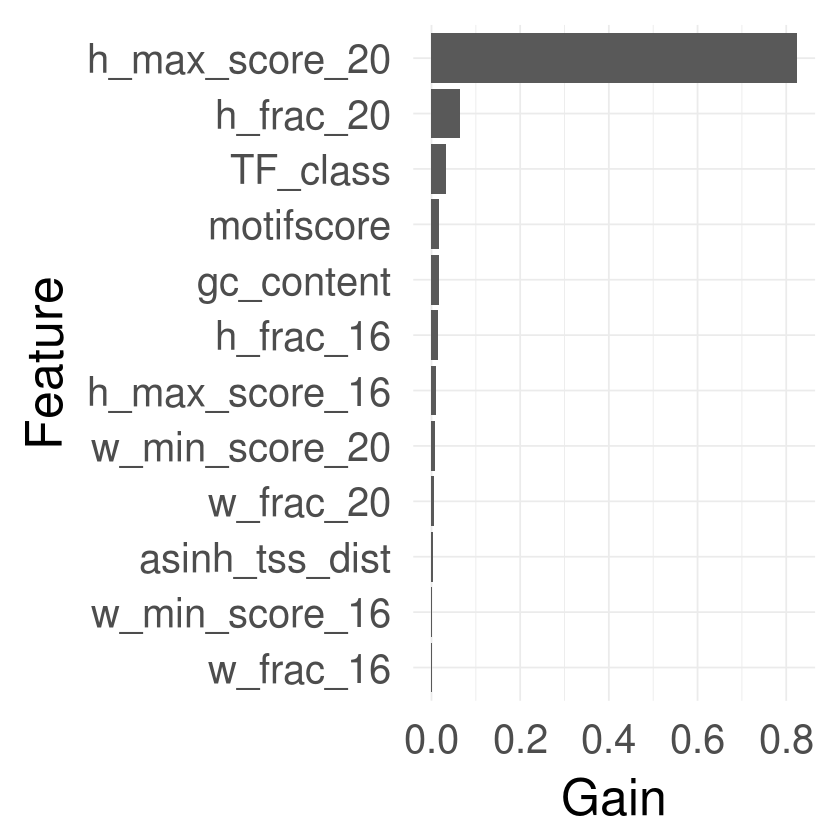

In [13]:
importance_matrix <- xgb.importance(colnames(X_train),model=gbdt_medium)

df <- as_data_frame(importance_matrix)
df.tf <- subset(df, Feature %in% unique(motif.class$class))
df.notf <- subset(df, !(Feature %in% unique(motif.class$class)))
tfclass.row <- c("TF_class", unname(as.list(colSums(df.tf[!(colnames(df.tf) %in% c("Feature"))]))) )
names(tfclass.row) <- colnames(df)
df.sum <- rbind(df.notf,tfclass.row)

ggplot(data=df.sum, aes(x=reorder(Feature, Gain), y=Gain)) +
    geom_bar(stat="identity") +
    coord_flip() +
    theme_minimal(base_size = 30) +
    labs(x = "Feature", y="Gain")

Now that we've checked out the features, we'll get back to the model. We're using 2 Rory functions that put together some stuff:

* `make.pred.df.from.model`
    * Takes in a model and runs `predict()` on it with the test data
    * Makes a data frame where it tacks on the actual response test data
    * Adds a column denoting the name of the model and returns it
* `make.stats.df.from.preds`
    * Takes in the data frame made by above function
    * Uses the `roc()` and `coords` functions in succession to generate ROC numbers (sensitivity, specificity, etc) for a range of points from 0 to 1
        * The range of points corresponds to the threshold for a prediction being classified as "TRUE"
    * Generates Matthews correlation coefficients, also for a range of thresholds from 0 to 1
        * Recall that these take into account TP/TN/FP/FN stuff
    * Adds the MCC to the ROC curve numbers, adds the name of the model, and returns the whole thing

In [14]:
medium_pred_df <- make.pred.df.from.model(gbdt_medium, X_test, y_test)
colnames(medium_pred_df)[1] <- "ChIPseq.bound"
medium_stat_df <- make.stats.df.from.preds(medium_pred_df)

Just to clarify, here's the two data frames:

In [15]:
head(medium_pred_df)

ChIPseq.bound,Prediction,Model.Name
1,0.7540353,trees with classes
1,0.7533107,trees with classes
1,0.6714107,trees with classes
1,0.6714107,trees with classes
1,0.6731601,trees with classes
1,0.6722810,trees with classes


In [16]:
head(medium_stat_df)

,threshold,sensitivity,specificity,ppv,npv,accuracy,MattCC,Model.Name
0,0.00,1,0,0.4433856,NaN,0.4433856,0,trees with classes
0.01,0.01,1,0,0.4433856,NaN,0.4433856,0,trees with classes
0.02,0.02,1,0,0.4433856,NaN,0.4433856,0,trees with classes
0.03,0.03,1,0,0.4433856,NaN,0.4433856,0,trees with classes
0.04,0.04,1,0,0.4433856,NaN,0.4433856,0,trees with classes
0.05,0.05,1,0,0.4433856,NaN,0.4433856,0,trees with classes


## Train a linear model on all features

Now we're going to do something a little different; instead of training a boosted tree model where we add lots of trees together, we're going to make some linear models. As such, we'll re-brand our data as the "linear" data:

In [17]:
X_train_lin <- X_train
y_train_lin <- y_train
X_test_lin  <- X_test
y_test_lin  <- y_test

We'll treat the TF classes differently here; we have to transform them to factors for the linear model, but that's fine. We're going to make a model called "glm small" where we use ALL the features, with each TF class as a factor variable. 

Note that this is logistic regression; we're using `family = binomial`

In [18]:
tf.regressors <- colnames(X_train_lin)[colnames(X_train_lin) %in% unique(motif.class$class)]
non.tf.regressors <-  colnames(X_train_lin)[!colnames(X_train_lin) %in% unique(motif.class$class)]

tf.regressors.formula <- paste("as.factor(", paste(tf.regressors, collapse=") + as.factor("), ")")
non.tf.regressors.formula <- paste(non.tf.regressors, collapse=" + ")
all.regressors.formula <- paste(non.tf.regressors.formula, tf.regressors.formula, sep=" + ")

glm.formula <- paste("ChIPseq.bound ~ ", all.regressors.formula, sep='')

glm.df.train <- as.data.frame(cbind(y_train_lin, X_train_lin)) %>% rename("cs_hit" = "ChIPseq.bound")
glm.df.test <-  as.data.frame(cbind(y_test_lin, X_test_lin)) %>% rename("cs_hit" = "ChIPseq.bound")

glm.all <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
glm.all$Model.Name <- "glm small"

As before, we'll predict on the test set and assemble prediction stats in a data frame; we won't show that, but it looks a lot like the one above

In [19]:
glm.pred.df <- make.pred.df.from.glm(glm.all, glm.df.test)
glm.stat.df <- make.stats.df.from.preds(glm.pred.df)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

## Linear Model on all Features Independently

Finally, we'll do it for each feature individually and make a model for each, naming them accordingly. We'll also grab the stats for each and bind them together. So what we have is a BIG data frame comprised of like 17 data frames stacked on top of each other. BUT, each model has its name, so we can find the data for each.

In [20]:
stats.regressors.df <- data.frame()

for (this.regressor in colnames(X_train_lin)) {
    
    if (this.regressor %in% unique(motif.class$class)) {
        glm.formula <- paste("ChIPseq.bound ~ ", "as.factor(", this.regressor, ")",sep='')
    } else {
        glm.formula <- paste("ChIPseq.bound ~ ", this.regressor,sep='')
    }

    glm.df.train <- as.data.frame(cbind(y_train_lin, X_train_lin)) %>% rename("cs_hit" = "ChIPseq.bound")
    glm.df.test <-  as.data.frame(cbind(y_test_lin, X_test_lin)) %>% rename("cs_hit" = "ChIPseq.bound")

    glm.single <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
    glm.single$Model.Name <- paste("glm ", this.regressor, sep='')
    
    glm.pred.single.df <- make.pred.df.from.glm(glm.single, glm.df.test)
    glm.stat.single.df <- make.stats.df.from.preds(glm.pred.single.df)
    
    stats.regressors.df <- rbind(stats.regressors.df, glm.stat.single.df)
    
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Now that we have all of our data frames stacked, we're going to filter out the 7 that are NOT a TF_class

In [21]:
stats.regressors.df %>% 
filter(Model.Name %in% c("glm motifscore",
                         "glm h_frac_16",
                         "glm h_max_score_16",
                         "glm w_frac_16",
                         "glm w_min_score_16",
                         "glm h_frac_20",
                         "glm h_max_score_20",
                         "glm w_frac_20",
                         "glm w_min_score_20",
                         "glm gc_content",
                         "glm asinh_tss_dist")) ->
stats.regressors.filtered.df

## compare performance

We're going to take the 7 single-factor linear models (stats.regressors.filtered), the gradient-boosted model (medium_stat), and the linear model with ALL regressors (glm.stat) and put them together. 

In [22]:
all.stats.df <- rbind(
    medium_stat_df,
    glm.stat.df,
    stats.regressors.filtered.df
)

In [23]:
save(all.stats.df, file = "/ssd/mrichard/data/joinedAllStats.Rdata")

Using another Rory function, we're going to plot the family of MCC curves. Note that the function:

* Plots a line using `geom_line`, with X = sensitivity and Y = PPV (positive predictive value)
* Separates the points by `Model.Name`
* Makes the scales 0-1
* Makes the plot square
* Labels the axes

Also note that the `theme_minimal` command controls the background (white) and whatnot

In [44]:
load("/ssd/mrichard/data/joinedAllStats.Rdata")

# Make a copy
all.stats.orig <- all.stats.df

In [45]:
# Screen out some models for visualization
all.stats.orig %>% 
filter(Model.Name %in% c(#"glm motifscore",
                         #"glm h_frac_16",
                         "glm h_max_score_16",
                         #"glm w_frac_16",
                         "glm w_min_score_16",
                         #"glm h_frac_20",
                         "glm h_max_score_20",
                         #"glm w_frac_20",
                         "glm w_min_score_20",
                         #"glm gc_content",
                         #"glm asinh_tss_dist",
                         "trees with classes",
                         "glm small"
                         )) -> all.stats.df

In [46]:
# Change labels and pull MCC
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm small'] <- 'linear model (all regressors)'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'trees with classes'] <- 'gradient boosted model'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm h_max_score_16'] <- 'HINT best score seed 16'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm h_max_score_20'] <- 'HINT best score seed 20'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm w_min_score_16'] <- 'Wellington best score seed 16'
all.stats.df$Model.Name[all.stats.df$Model.Name== 'glm w_min_score_20'] <- 'Wellington best score seed 20'

max(all.stats.df$MattCC)

[1] 0.7119653

In [47]:
# Create color palette
myPalette <- c("black","red","blue","green2","darkorange","purple","magenta","brown","cyan")
myColors <- myPalette[1:6]
names(myColors) <- c('gradient boosted model',
                     'linear model (all regressors)',
                     'HINT best score seed 16',
                     'HINT best score seed 20',
                     'Wellington best score seed 16',
                     'Wellington best score seed 20'
                    )
colScale <- scale_colour_manual(name = "Model.Name",values = myColors)

In [48]:
# Reorder model names
all.stats.df$Model.Name <- factor(all.stats.df$Model.Name,
                                  levels = c('gradient boosted model',
                                             'linear model (all regressors)',
                                             'HINT best score seed 16',
                                             'HINT best score seed 20',
                                             'Wellington best score seed 16',
                                             'Wellington best score seed 20'
                    )
                                 )

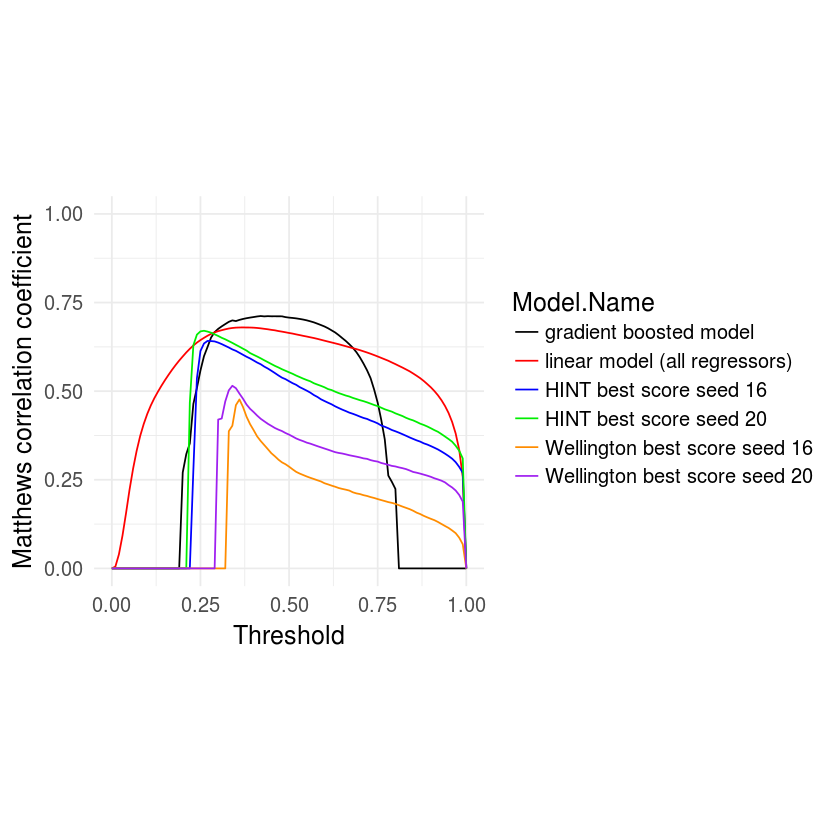

In [49]:
plot.mattcc.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale

Now we'll do the same, only this time we'll plot the ROC curves. Recall that this is Sensitivity v. 1-Specificity, so Rory has named the axes accordingly. The function he wrote also allows you to label the area under the curve, but we don't do it here because....frankly, it'd be a mess with so many curves. 

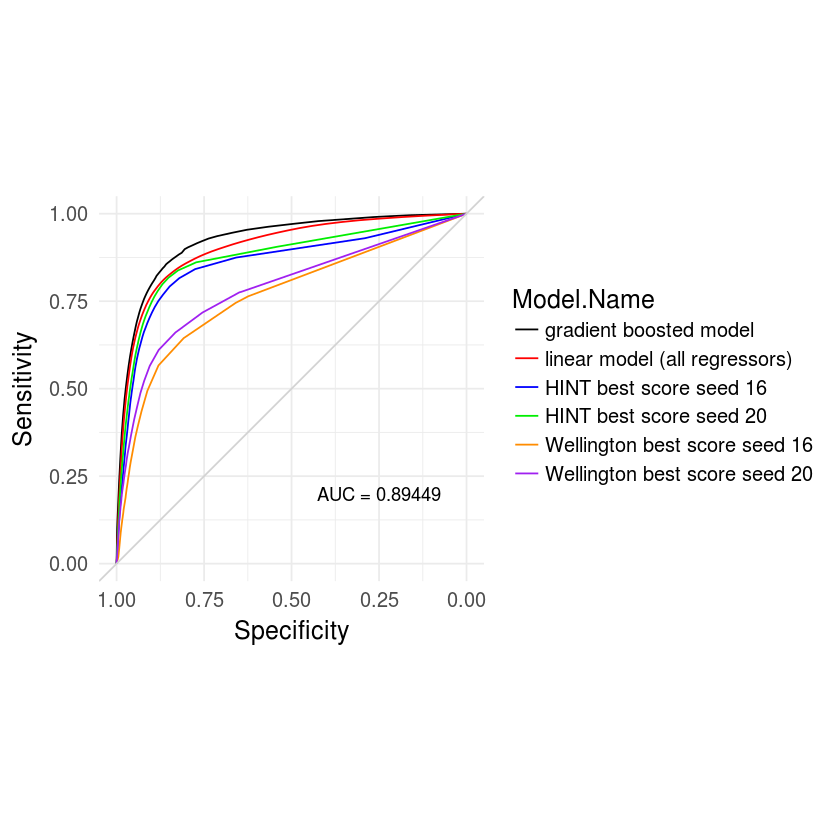

In [50]:
plot.roc.curve(all.stats.df, TRUE) + theme_minimal(base_size = 15) + colScale

The last plot is a bit trickier, we're plotting "recall" v. precision. What are these exactly?

* Recall: sensitivity; how good you are at only picking out 
* Precision:  PPV; how well you can pick out only the true positives (P/TP)

What we're actually plotting here is PPV (positive predictive value) versus sensitivity. So I think we're just using synonyms here. The rest of the function just scales the plot from 0-1.

The idea is we should try to maximize both things, so we can see that the GBM model does the best, again

** Is it possible that the axis labels are switched?? **

Warning message:
“Removed 25 rows containing missing values (geom_path).”

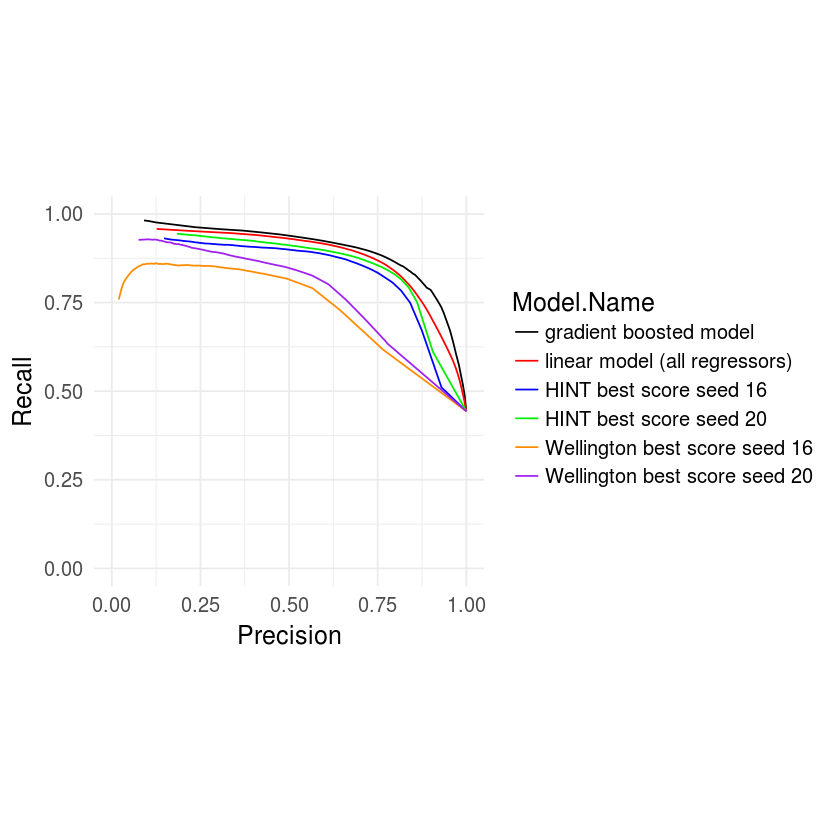

In [51]:
plot.precrecall.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale

# Recreate figures as pngs

In [52]:
png("./figures/joinedMCC.png") 
plot.mattcc.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale
dev.off()

png 
  2

In [53]:
png("./figures/joinedROC.png")
plot.roc.curve(all.stats.df, TRUE) + theme_minimal(base_size = 15) + colScale
dev.off()

png 
  2

In [54]:
png("./figures/joinedPreRec.png")
plot.precrecall.curve(all.stats.df) + theme_minimal(base_size = 15) + colScale
dev.off()

Warning message:
“Removed 25 rows containing missing values (geom_path).”

png 
  2

In [55]:
# Load the model and get the importance matrix, plus combine the motif class info
gbdt_medium <- xgb.load("saved_models/xgboost_TF_site_predict_joined.model")
motif.class$class <- lapply(motif.class$class, make.names, unique=TRUE)
class(gbdt_medium)

[1] "xgb.Booster"

In [56]:
importance_matrix <- xgb.importance(colnames(X_train),model=gbdt_medium)

df <- as_data_frame(importance_matrix)
df.tf <- subset(df, Feature %in% unique(motif.class$class))
df.notf <- subset(df, !(Feature %in% unique(motif.class$class)))
tfclass.row <- c("TF_class", unname(as.list(colSums(df.tf[!(colnames(df.tf) %in% c("Feature"))]))) )
names(tfclass.row) <- colnames(df)
df.sum <- rbind(df.notf,tfclass.row)

# Save to a png
png("./figures/joinedImpMatrix.png")
ggplot(data=df.sum, aes(x=reorder(Feature, Gain), y=Gain)) +
    geom_bar(stat="identity") +
    coord_flip() +
    theme_minimal(base_size = 30) +
    labs(x = "Feature", y="Gain")
dev.off()

png 
  2